In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from helpers.items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from helpers.testing import Tester

In [4]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI


In [9]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nMinneer Racing Steering Simulator Cockpit Red with TV Bracket Mounting Holes Racing Wheel Stand/Fits Logitech G25, G27, G29/ Compatible with Xbox One, Playstation, PC Platforms with Capacity 220LBS\nPrice Guarantee#：If the price drops within 30 days of purchase, please contact us by email. We will arrange a refund of the price difference for you. Compatible with all racing wheels Thrustmaster, logitech, fanatec; fully customizable. Wide racing seat with thick padding, seat sliders and angle adjustment. Support the front and back adjustment of the seat and adjust the angle of the backrest. Compact, easy to foldable, easy to move, easy to store away. All mounting hardware and tools included. Ready to use right out the'},
 {'role': 'assistant', 'content': 'Price is $344.99'}]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nMinneer Racing Steering Simulator Cockpit Red with TV Bracket Mounting Holes Racing Wheel Stand/Fits Logitech G25, G27, G29/ Compatible with Xbox One, Playstation, PC Platforms with Capacity 220LBS\nPrice Guarantee#\uff1aIf the price drops within 30 days of purchase, please contact us by email. We will arrange a refund of the price difference for you. Compatible with all racing wheels Thrustmaster, logitech, fanatec; fully customizable. Wide racing seat with thick padding, seat sliders and angle adjustment. Support the front and back adjustment of the seat and adjust the angle of the backrest. Compact, easy to foldable, easy to move, easy to store away. All mounting hardware and tools included. Ready to use right out the"}, {"role": "assistant", "content": "Price is $344.99"}]}
{"messages": [{"role": "system", "

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-R2T9LHB7LEAA2zTLJfFPX4', bytes=194497, created_at=1737037688, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-Q6DAmqcECbAzbLSko6JbDG', bytes=47810, created_at=1737037729, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

Step 2 
Fine tuning 

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-R2T9LHB7LEAA2zTLJfFPX4'

In [22]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw', created_at=1737039148, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-mt8MTGQ32F09Gl0L1uHlK0TG', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-R2T9LHB7LEAA2zTLJfFPX4', validation_file='file-Q6DAmqcECbAzbLSko6JbDG', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw'))], user_provided_suffix='pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 1}}})

In [23]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw', created_at=1737039148, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-mt8MTGQ32F09Gl0L1uHlK0TG', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-R2T9LHB7LEAA2zTLJfFPX4', validation_file='file-Q6DAmqcECbAzbLSko6JbDG', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw'))], user_provided_suffix='pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 1, 'batch_size': 'auto', 'learning_rate_multiplier': 'auto'}}})], object='list', has_more=False)

In [24]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [25]:
job_id

'ftjob-G3pUQTFDRrn58Q8O1PI0KXVw'

In [26]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw', created_at=1737039148, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-mt8MTGQ32F09Gl0L1uHlK0TG', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-R2T9LHB7LEAA2zTLJfFPX4', validation_file='file-Q6DAmqcECbAzbLSko6JbDG', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G3pUQTFDRrn58Q8O1PI0KXVw'))], user_provided_suffix='pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 1, 'batch_size': 1, 'learning_rate_multiplier': 1.8}}})

In [38]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-ZBKkZ89c8WXqCUWAlhyUm6u8', created_at=1737039738, level='info', message='Step 200/200: training loss=1.14, validation loss=0.43, full validation loss=0.98', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.141812801361084, 'valid_loss': 0.4325230121612549, 'total_steps': 200, 'full_valid_loss': 0.9834856081008911, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.875, 'full_valid_mean_token_accuracy': 0.7925}, type='metrics'),
 FineTuningJobEvent(id='ftevent-o3NUcpAERMN2UBb5CbetAdzn', created_at=1737039733, level='info', message='Step 199/200: training loss=1.03', object='fine_tuning.job.event', data={'step': 199, 'train_loss': 1.0285546779632568, 'total_steps': 200, 'train_mean_token_accuracy': 0.875}, type='metrics'),
 FineTuningJobEvent(id='ftevent-eaKCFLauy813gcCiNAMeE3TN', created_at=1737039731, level='info', message='Step 198/200: training loss=0.39', object='fine_tuning.job.event', data={'step': 198, 'train_loss':

Step 3

Test our fine tuned model

In [39]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [40]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:AqLh5I7Q'

In [41]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [42]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nThe Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap\n“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [43]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [44]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [45]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [46]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

35.0
14.98


In [47]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

The Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap
“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when

Price is $


1: Guess: $14.98 Truth: $35.00 Error: $20.02 SLE: 0.66 Item: The Phantom of the Opera Gaston Leroux C...
2: Guess: $127.22 Truth: $135.99 Error: $8.77 SLE: 0.00 Item: Norcold 628970 Fridge Part
3: Guess: $129.99 Truth: $178.43 Error: $48.44 SLE: 0.10 Item: SPT RF-244SS Compact Refrigerator, Stain...
4: Guess: $23.47 Truth: $6.98 Error: $16.49 SLE: 1.26 Item: Letter Red B Balloons,40 Inch Single Red...
5: Guess: $83.99 Truth: $45.99 Error: $38.00 SLE: 0.35 Item: Konami Classics Arcade Hits - Nintendo D...
6: Guess: $127.99 Truth: $88.99 Error: $39.00 SLE: 0.13 Item: Mini Washing Machine, Portable Washer fo...
7: Guess: $118.00 Truth: $104.95 Error: $13.05 SLE: 0.01 Item: Farmhouse Buffalo Plaid Wreath - Front D...
8: Guess: $47.22 Truth: $215.00 Error: $167.78 SLE: 2.25 Item: Corpse Party: Back to School Edition - N...
9: Guess: $239.00 Truth: $75.00 Error: $164.00 SLE: 1.32 Item: True leather case for Microsoft Surface ...
10: Guess: $65.98 Truth: $97.71 Error: $31.73 SLE: 0.15 Item: V

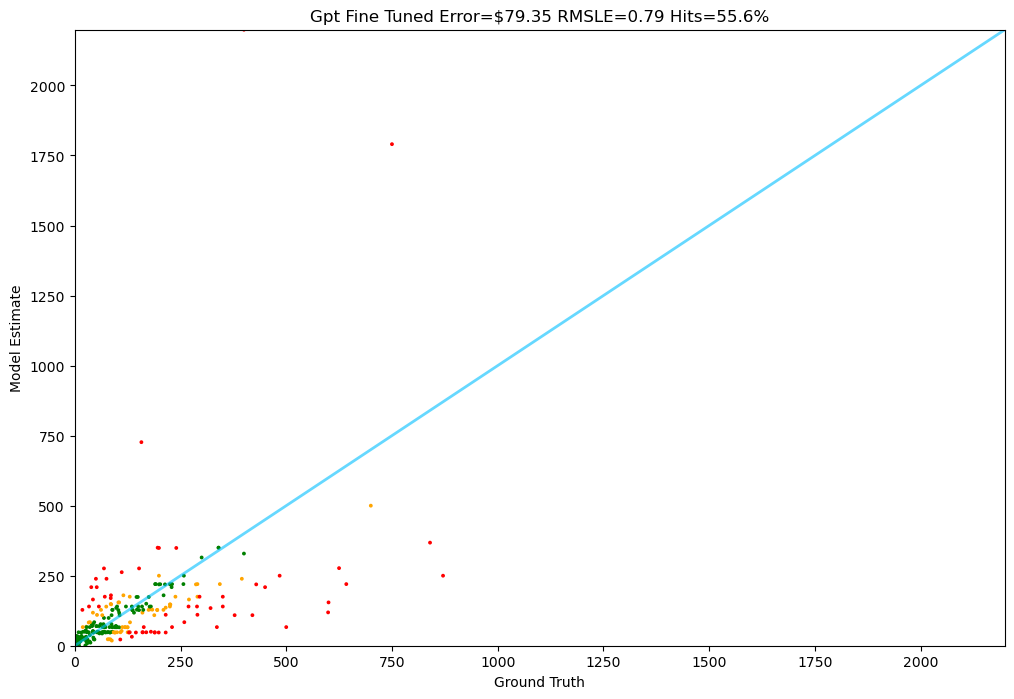

In [48]:
Tester.test(gpt_fine_tuned, test)